In [1]:
import pybaseball as pyb
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import matplotlib.colors as colors
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)

In [2]:
mlb_21=pd.read_csv('mlb_21.csv').drop('Unnamed: 0', axis=1)

# RE 계산

In [3]:
data21 = mlb_21.copy()
events21 = data21[data21['events'].notnull()]

In [4]:
def calculation(event):
    total_game = pd.DataFrame()
    game_id = np.array(event['game_pk'].unique())
    for i in game_id:
        game = event[event['game_pk']==i]
        # 타석 순으로 정리
        game = game.sort_values(by='at_bat_number')

        # Start에서
        # 1B, 2B, 3B에 주자가 없을 경우, 0으로
        # 1B, 2B, 3B가 주자가 있을 경우, 1으로
        game['Start1'] = np.where(game['on_1b'].isnull(),0,1)
        game['Start2'] = np.where(game['on_2b'].isnull(),0,1)
        game['Start3'] = np.where(game['on_3b'].isnull(),0,1)

        # Start 주자 상황과 아웃카운트 병합
        game['Start_State'] = (game['Start1'].astype(str) + game['Start2'].astype(str) + game['Start3'].astype(str)+" " + game['outs_when_up'].astype(str))


        # End에서
        # 아웃카운트 계산 (이닝이 종료되었을 경우 3)
        game['end_out'] = game['outs_when_up'].shift(-1)
        game['end_out'] = np.where(game['end_out'].isnull(), 3, game['end_out'])
        game['end_out'] = np.where(((game['end_out']==0) & (game['outs_when_up']!=0)), 3, game['end_out'])
        game['end_out'] = game['end_out'].astype('int')

        # End에서
        # 1B, 2B, 3B에 주자가 없을 경우, 0으로
        # 1B, 2B, 3B가 주자가 있을 경우, 1으로
        game['end_1'] = game['Start1'].shift(-1)
        game['end_1'] = np.where((game['end_1'].isnull())|(game['end_out']==3), 0, game['end_1'])
        game['end_2'] = game['Start2'].shift(-1)
        game['end_2'] = np.where((game['end_2'].isnull())|(game['end_out']==3), 0, game['end_2'])
        game['end_3'] = game['Start3'].shift(-1)
        game['end_3'] = np.where((game['end_3'].isnull())|(game['end_out']==3), 0, game['end_3'])
        game[['end_1', 'end_2', 'end_3']]= game[['end_1', 'end_2', 'end_3']].astype('int')

        # End 주자 상황과 아웃카운트 병합
        game['End_State'] = (game['end_1'].astype(str) + game['end_2'].astype(str) + game['end_3'].astype(str)+" " + game['end_out'].astype(str))


        # 이닝당 득점한 점수 계산
        score = game.groupby(['inning', 'inning_topbot'])['bat_score'].max().reset_index().rename(columns={'bat_score': 'inning_score'})
        game = pd.merge(game, score, on=['inning', 'inning_topbot'])

        # 9회말 끝내기는 아웃카운트에 상관없이 경기가 끝나서 3아웃까지 채우지 않고도 경기가 끝나버린다.
        # 3아웃을 기준으로 측정한 run_expectancy에 영향이 가기 때문에 제외한다.
        if (game.iloc[-1]['inning_topbot']=='Bot') & (game.iloc[-1]['post_bat_score']>game.iloc[-1]['post_fld_score']):
            game.drop(game[(game['inning']==game['inning'].max()) & (game['inning_topbot']=='Bot')].index)

        # 현재 상황에서 이닝이 종료될때 까지의 득점 계산
        game['futureRun'] = game['inning_score'] - game['bat_score']


        # 모든 경기 데이터 병합
        total_game = pd.concat([total_game, game])

    return total_game

In [5]:
def run_value(df):
    start_RunExp = df.groupby(['Start_State'])['futureRun'].mean().reset_index().rename(columns={'futureRun': 'Start_RE'})
    start_RunExp = start_RunExp.append({'Start_State': '000 3', 'Start_RE': 0}, ignore_index=True)
    end_RunExp = start_RunExp.rename(columns={'Start_State':'End_State', 'Start_RE':'End_RE'})

    df = pd.merge(df, start_RunExp, on=['Start_State'], how='left')
    df = pd.merge(df, end_RunExp, on=['End_State'], how='left')


    # Run Value: 타자의 득점 + (End State와 Start State의 득점 기대값 차이)
    # 1득점당 Run Value는 1로 계산
    # 득점 = post_bat_score - bat_score
    # 타석 후의 득점 기대값의 변화량 (End_RE - Start_RE)
    df['Start_RE'] = df['Start_RE'].astype('float32')
    df['End_RE'] = df['End_RE'].astype('float32')
    df['Run_Value'] = df['post_bat_score'] - df['bat_score'] + df['End_RE'] - df['Start_RE']
    
    return df

In [6]:
df_21 = calculation(events21)
re_21 =run_value(df_21)

In [7]:
re_21

,pitch_type,game_date,release_speed,release_pos_x,release_pos_z,player_name,batter,pitcher,events,description,spin_dir,spin_rate_deprecated,break_angle_deprecated,break_length_deprecated,zone,des,game_type,stand,p_throws,home_team,away_team,type,hit_location,bb_type,balls,strikes,game_year,pfx_x,pfx_z,plate_x,plate_z,on_3b,on_2b,on_1b,outs_when_up,inning,inning_topbot,hc_x,hc_y,tfs_deprecated,tfs_zulu_deprecated,fielder_2,umpire,sv_id,vx0,vy0,vz0,ax,ay,az,sz_top,sz_bot,hit_distance_sc,launch_speed,launch_angle,effective_speed,release_spin_rate,release_extension,game_pk,pitcher.1,fielder_2.1,fielder_3,fielder_4,fielder_5,fielder_6,fielder_7,fielder_8,fielder_9,release_pos_y,estimated_ba_using_speedangle,estimated_woba_using_speedangle,woba_value,woba_denom,babip_value,iso_value,launch_speed_angle,at_bat_number,pitch_number,pitch_name,home_score,away_score,bat_score,fld_score,post_away_score,post_home_score,post_bat_score,post_fld_score,if_fielding_alignment,of_fielding_alignment,spin_axis,delta_home_win_exp,delta_run_exp,Start1,Start2,Start3,Start_State,end_out,end_1,end_2,end_3,End_State,inning_score,futureRun,Start_RE,End_RE,Run_Value
0,FF,2021-10-03,95.2,-2.03,5.51,"Morton, Charlie",607043,450203,field_out,hit_into_play,NaN,NaN,NaN,NaN,5.0,Brandon Nimmo lines out sharply to center fiel...,R,L,R,ATL,NYM,X,8.0,line_drive,2,1,2021,-1.06,0.87,0.08,2.71,NaN,NaN,NaN,0,1,Top,103.51,55.40,NaN,NaN,518595,NaN,NaN,7.891649,-138.385344,-3.647668,-15.362180,30.666890,-20.363001,3.49,1.60,360.0,102.0,20.0,95.1,2409.0,6.3,632254,450203,518595,518692,645277,663586,621020,592696,594807,624585,54.20,0.526,0.699,0.0,1.0,0.0,0.0,5.0,1,4,4-Seam Fastball,0,0,0,0,0,0,0,0,Standard,Standard,235.0,0.022,-0.282,0,0,0,000 0,1,0,0,0,000 1,0,0,0.500158,0.261403,-0.238755
1,FF,2021-10-03,96.9,-1.90,5.65,"Morton, Charlie",596019,450203,field_out,hit_into_play,NaN,NaN,NaN,NaN,6.0,Francisco Lindor flies out to center fielder A...,R,L,R,ATL,NYM,X,8.0,fly_ball,1,2,2021,-1.02,0.80,0.42,2.33,NaN,NaN,NaN,1,1,Top,108.69,56.81,NaN,NaN,518595,NaN,NaN,8.516158,-140.826806,-5.147762,-15.482124,30.088537,-20.575831,3.32,1.51,355.0,94.3,27.0,96.9,2392.0,6.2,632254,450203,518595,518692,645277,663586,621020,592696,594807,624585,54.26,0.171,0.231,0.0,1.0,0.0,0.0,3.0,2,4,4-Seam Fastball,0,0,0,0,0,0,0,0,Standard,Standard,237.0,0.015,-0.114,0,0,0,000 1,2,0,0,0,000 2,0,0,0.261403,0.100258,-0.161145
2,CU,2021-10-03,80.7,-2.27,5.41,"Morton, Charlie",624424,450203,strikeout,called_strike,NaN,NaN,NaN,NaN,7.0,Michael Conforto called out on strikes.,R,L,R,ATL,NYM,S,2.0,NaN,2,2,2021,1.57,-0.76,-0.83,2.06,NaN,NaN,NaN,2,1,Top,NaN,NaN,NaN,NaN,518595,NaN,NaN,0.204328,-117.419720,0.739756,14.296048,25.728871,-39.517770,3.29,1.58,NaN,NaN,NaN,80.1,3024.0,6.2,632254,450203,518595,518692,645277,663586,621020,592696,594807,624585,54.27,NaN,NaN,0.0,1.0,0.0,0.0,NaN,3,6,Curveball,0,0,0,0,0,0,0,0,Infield shift,Standard,57.0,0.010,-0.091,0,0,0,000 2,3,0,0,0,000 3,0,0,0.100258,0.000000,-0.100258
3,SI,2021-10-03,94.4,-0.64,6.47,"Syndergaard, Noah",624585,592789,home_run,hit_into_play,NaN,NaN,NaN,NaN,5.0,Jorge Soler homers (27) on a line drive to lef...,R,R,R,ATL,NYM,X,NaN,line_drive,0,1,2021,-1.05,0.78,0.03,2.56,NaN,NaN,NaN,0,1,Bot,6.31,88.31,NaN,NaN,664850,NaN,NaN,4.139635,-137.355919,-6.265398,-14.270324,30.449621,-21.125769,3.55,1.63,399.0,117.9,21.0,95.1,2082.0,6.7,632254,592789,664850,624413,606299,542340,596019,642086,607043,624424,53.80,0.949,1.705,2.0,1.0,0.0,3.0,6.0,4,2,Sinker,0,0,0,0,0,1,1,0,Infield shift,Standard,200.0,0.102,1.038,0,0,0,000 0,0,0,0,0,000 0,2,2,0.500158,0.500158,1.000000
4,FF,2021-10-03,92.8,-0.70,6.33,"Syndergaard, Noah",518692,592789,field_out,hit_into_play,NaN,NaN,NaN,NaN,8.0,Freddie Freeman flies out sharply to left fiel...,R,L,R,ATL,NYM,X,7.0,fly_ball,2,1,2021,-0.34,1.16,0.10,1.90,NaN,NaN,NaN,0,1,Bot,65.96,110.50,NaN,NaN,664850,NaN,NaN,2.830407,-135.035331,-8.169452,-4.816009,29.277051,-16.389516,3.58,1.68,265.0,101.9,59.0,93.7,2055.0,6.8,632254,592789,664850,624413,60

In [8]:
# 21시즌 데이터
run_exp_21 = re_21.groupby(['Start_State'])['futureRun'].mean().reset_index().rename(columns={'Start_State':'State', 'futureRun':'RE'})
run_exp_0003 = pd.DataFrame([['000 3', 0]], columns=['State', 'RE'])
run_exp_21 = run_exp_21.append(run_exp_0003)

# Win Probability 측정 model 생성

In [9]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [10]:
### 21 시즌

score21 = events21[['game_pk', 'inning', 'inning_topbot', 'outs_when_up', 'at_bat_number', 'home_score', 'away_score', 'post_home_score', 'post_away_score']]
max_score21 = score21.groupby('game_pk').agg({'post_home_score': 'max', 'post_away_score': 'max'}).reset_index().rename(columns={'post_home_score': 'final_home', 'post_away_score': 'final_away'})

inning_score21 = score21.groupby(['game_pk', 'inning', 'inning_topbot']).agg({'post_home_score': 'max', 'post_away_score': 'max'}).reset_index()
inning_score21 = inning_score21.sort_values(by=['game_pk', 'inning', 'inning_topbot'],
                 ascending=[True, True, False])
inning_score21 = pd.merge(inning_score21, max_score21, on='game_pk')

inning_score21['diff'] = (inning_score21['post_home_score']-inning_score21['post_away_score']).astype('int')

inning_score21['result'] = np.where(inning_score21['final_home']>inning_score21['final_away'], 1, 0).astype('int')

final21 = inning_score21.rename(columns={'post_home_score': 'home_score', 'post_away_score': 'away_score'})
final21

,game_pk,inning,inning_topbot,home_score,away_score,final_home,final_away,diff,result
0,632169,1,Top,0,0,4,3,0,1
1,632169,1,Bot,0,0,4,3,0,1
2,632169,2,Top,0,0,4,3,0,1
3,632169,2,Bot,0,0,4,3,0,1
4,632169,3,Top,0,0,4,3,0,1
...,...,...,...,...,...,...,...,...,...
42753,634656,5,Bot,2,5,2,6,-3,0
42754,634656,6,Top,2,5,2,6,-3,0
42755,634656,6,Bot,2,5,2,6,-3,0
42756,634656,7,Top,2,6,2,6,-4,0


In [11]:
## 21시즌 홈 경기 승률
home_win_prob21 = final21['result'].mean()
home_win_prob21

0.5260769914401984

In [12]:
# 각 이닝의 로지스틱 회귀 계수를 beta0, beta1에 저장

beta0 = []
beta1 = []
for i in range(1,9):
    for j in ['Top', 'Bot']:
        logistic = smf.glm(formula='result ~ diff', data=final21[(final21['inning']==i)&(final21['inning_topbot']==j)], family=sm.families.Binomial()).fit()
        beta0.append(logistic.params[0])
        beta1.append(logistic.params[1])

In [13]:
s0 = pd.DataFrame({'Half_Inning':[0], 'Beta0': [np.log(home_win_prob21/(1-home_win_prob21))], 'Beta1': None, 'inning': [0], 'inning_topbot': ['Bot']})
s1 = pd.DataFrame({'Half_Inning':np.arange(1,17), 'Beta0': beta0, 'Beta1': beta1})
s2 = pd.DataFrame({'Half_Inning':np.arange(17,51), 'Beta0': [s1['Beta0'].iloc[14], s1['Beta0'].iloc[15]]*17, 'Beta1': [s1['Beta1'].iloc[14], s1['Beta1'].iloc[15]]*17})
s3 = pd.concat([s1, s2])

from itertools import cycle
s3['inning'] = (s3['Half_Inning']+1)//2
top_bot = cycle(['Top', 'Bot'])
s3['inning_topbot'] = [next(top_bot) for num in range(len(s3))]

s = pd.concat([s0, s3])

In [14]:
s.head(20)

,Half_Inning,Beta0,Beta1,inning,inning_topbot
0,0,0.104403,None,0,Bot
0,1,0.359454,0.422349,1,Top
1,2,0.124664,0.465767,1,Bot
2,3,0.316546,0.484686,2,Top
3,4,0.106561,0.479758,2,Bot
4,5,0.331206,0.47524,3,Top
5,6,0.082424,0.531188,3,Bot
6,7,0.332008,0.551918,4,Top
7,8,0.040896,0.601841,4,Bot
8,9,0.339280,0.622229,5,Top


# Win Probability

In [15]:
# 모든 데이터에 위의 계산된 beta0, beta1을 이닝과 top,bot에 맞게 대입
win_p = re_21.copy()
win_p['runs0'] = np.where(win_p['inning_topbot']=='Bot', win_p['home_score']-win_p['away_score']+win_p['Start_RE'], win_p['home_score']-win_p['away_score']-win_p['Start_RE'])
win_p['runs1'] = np.where(win_p['inning_topbot']=='Bot', win_p['post_home_score']-win_p['post_away_score']+win_p['End_RE'], win_p['post_home_score']-win_p['post_away_score']-win_p['End_RE'])
win_p = pd.merge(win_p, s[['inning', 'inning_topbot', 'Beta0', 'Beta1']], on=['inning', 'inning_topbot'])

In [16]:
# 승리 확률과 wpa 계산

def inv_log_odds(x):
    return np.exp(x)/(1+np.exp(x))

win_p['p_start'] = list(map(inv_log_odds, win_p['Beta0'] + (win_p['Beta1']*win_p['runs0'])))
win_p['p_end'] = list(map(inv_log_odds, win_p['Beta0'] + (win_p['Beta1']*win_p['runs1'])))
win_p['wpa'] = win_p['p_end'] - win_p['p_start']

In [17]:
wpa0 = win_p[['game_pk', 'game_date', 'player_name', 'pitch_name', 'batter', 'events', 'description', 'home_team', 'away_team',
       'inning', 'inning_topbot', 'outs_when_up', 'at_bat_number', 'home_score', 'away_score', 'post_home_score', 'post_away_score',
      'Start_State', 'End_State', 'Start_RE', 'End_RE', 'Run_Value', 'runs0', 'runs1', 'Beta0', 'Beta1', 'p_start', 'p_end', 'wpa', 'delta_home_win_exp']]

# 경기 마지막 이벤트는 승률을 0 또는 1로 바꾸게 설정
last_event = wpa0.groupby('game_pk').tail(1)
last_event['p_end'] = np.where(last_event['post_home_score']>=last_event['post_away_score'],1,0)
last_event['wpa'] = last_event['p_end'] - last_event['p_start']

last_event_index = last_event.index
wpa1 = wpa0.loc[~wpa0.index.isin(last_event_index)]
wpa = pd.concat([wpa1, last_event]).sort_values(by=['game_date', 'game_pk', 'at_bat_number'])

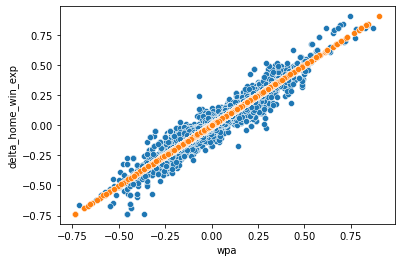

In [18]:
# 계산한 wpa와 스탯캐스트에서 제공하는 wpa 비교

sns.scatterplot(wpa['wpa'], wpa['delta_home_win_exp'])
sns.scatterplot(wpa['delta_home_win_exp'], wpa['delta_home_win_exp'])
plt.show()

In [19]:
# 타자 이름 추가
player_list = np.array(wpa['batter'])
player_data = pyb.playerid_reverse_lookup(player_list, key_type='mlbam')
player_data['batter_name'] = player_data['name_last'].str.title() + ', ' + player_data['name_first'].str.title()
player_name = player_data[['key_mlbam', 'batter_name']].rename(columns={'key_mlbam': 'batter'})
wpa = pd.merge(wpa, player_name, on='batter')

Gathering player lookup table. This may take a moment.


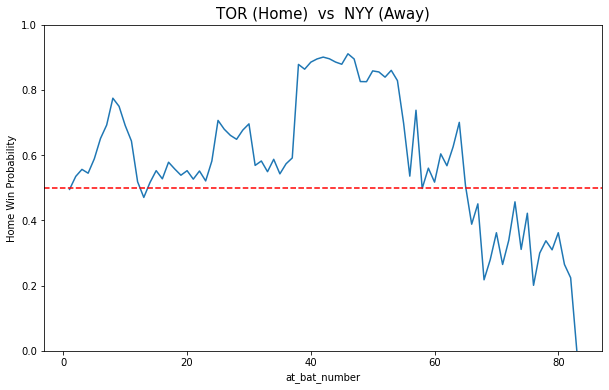

In [20]:
# 실제 경기에 대입하여 홈팀 승률 변화 그래프 생성
# 21시즌 5월20일 토론토(홈)와 보스턴(어웨이)과의 경기

test = wpa[(wpa['game_pk']==633653)]

plt.figure(figsize=(10,6))
sns.lineplot(test['at_bat_number'], test['p_end'])
plt.axhline(0.5, color='red', linestyle='--')
plt.ylim(0,1)
plt.ylabel('Home Win Probability')
plt.title(test['home_team'].iloc[0]+' (Home)' +'  vs  '+ test['away_team'].iloc[0]+' (Away)', fontsize=15)
plt.show()

In [21]:
test

,game_pk,game_date,player_name,pitch_name,batter,events,description,home_team,away_team,inning,inning_topbot,outs_when_up,at_bat_number,home_score,away_score,post_home_score,post_away_score,Start_State,End_State,Start_RE,End_RE,Run_Value,runs0,runs1,Beta0,Beta1,p_start,p_end,wpa,delta_home_win_exp,batter_name
79906,633653,2021-06-15,"Montgomery, Jordan",Sinker,543760,walk,ball,TOR,NYY,1,Bot,0,6,0,0,0,0,000 0,010 0,0.500158,1.072984,0.572826,0.500158,1.072984,0.124664,0.465767,0.588464,0.651224,0.062760,0.036,"Semien, Marcus"
79907,633653,2021-06-15,"Montgomery, Jordan",Sinker,543760,field_out,hit_into_play,TOR,NYY,2,Bot,2,21,1,1,1,1,100 2,000 3,0.217478,0.000000,-0.217478,0.217478,0.000000,0.106561,0.479758,0.552530,0.526615,-0.025915,-0.024,"Semien, Marcus"
79908,633653,2021-06-15,"Montgomery, Jordan",Changeup,543760,single,hit_into_play,TOR,NYY,4,Bot,2,37,2,2,2,2,110 2,011 2,0.425480,0.547756,0.122276,0.425480,0.547756,0.040896,0.601841,0.573701,0.591594,0.017893,0.034,"Semien, Marcus"
79909,633653,2021-06-15,"Cessa, Luis",4-Seam Fastball,543760,strikeout,swinging_strike,TOR,NYY,6,Bot,2,54,5,3,5,3,010 2,000 3,0.313497,0.000000,-0.313497,2.313497,2.000000,0.045759,0.765299,0.860119,0.828688,-0.031431,-0.021,"Semien, Marcus"
79910,633653,2021-06-15,"Britton, Zack",Sinker,543760,walk,ball,TOR,NYY,8,Bot,2,75,5,6,5,6,110 2,111 2,0.425480,0.774608,0.349127,-0.574520,-0.225392,-0.004623,1.374956,0.311190,0.422010,0.110820,0.076,"Semien, Marcus"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
174070,633653,2021-06-15,"Mayza, Tim",Sinker,656467,strikeout,swinging_strike,TOR,NYY,8,Top,0,67,5,5,5,5,100 0,010 1,0.896513,0.659109,-0.237404,-0.896513,-0.659109,0.514481,1.08005,0.388458,0.450812,0.062354,0.065,"Gittens, Chris"
174496,633653,2021-06-15,"Montgomery, Jordan",Changeup,656180,strikeout,foul_tip,TOR,NYY,2,Bot,1,19,1,1,1,1,000 1,000 2,0.261403,0.100258,-0.161145,0.261403,0.100258,0.106561,0.479758,0.557734,0.538588,-0.019146,-0.016,"Adams, Riley"
174497,633653,2021-06-15,"Montgomery, Jordan",Changeup,656180,field_out,hit_into_play,TOR,NYY,4,Bot,1,35,2,2,2,2,100 1,100 2,0.518976,0.217478,-0.301498,0.518976,0.217478,0.040896,0.601841,0.587402,0.542840,-0.044562,-0.034,"Adams, Riley"
174498,633653,2021-06-15,"Cessa, Luis",Sinker,656180,field_out,hit_into_play,TOR,NYY,6,Bot,1,52,5,3,5,3,000 1,000 2,0.261403,0.100258,-0.161145,2.261403,2.100258,0.045759,0.765299,0.855253,0.839307,-0.015945,-0.009,"Adams, Riley"


In [22]:
# Top 5 플레이

test['abs_wpa'] = test['wpa'].abs()
test.sort_values(by='abs_wpa', ascending=False)[['player_name', 'batter_name', 'inning', 'inning_topbot', 'away_score', 'home_score', 'Start_State', 'events', 'wpa']].rename(columns={'player_name':'pitcher_name'}).head(5)

,pitcher_name,batter_name,inning,inning_topbot,away_score,home_score,Start_State,events,wpa
87860,"Romano, Jordan","Frazier, Clint",8,Top,5,5,010 1,double,-0.232826
85171,"Chapman, Aroldis","Grichuk, Randal",9,Bot,6,5,000 2,field_out,-0.224135
80925,"Britton, Zack","Bichette, Bo",8,Bot,6,5,111 2,field_out,-0.220933
82261,"Castro, Anthony","Judge, Aaron",7,Top,4,5,001 0,strikeout,0.202024
85170,"Loáisiga, Jonathan","Grichuk, Randal",7,Bot,5,5,110 1,grounded_into_double_play,-0.193804


In [23]:
wpa['wpa_ab'] = np.abs(wpa['wpa'])
wpa_hr = wpa[wpa['events']=='home_run']
hr_comp = wpa_hr.groupby(['batter', 'batter_name']).agg({'game_pk': 'count', 'wpa_ab': 'mean'}).reset_index().rename(columns={'game_pk': 'count'})
hr_comp.sort_values(by='count', ascending=False)

,batter,batter_name,count,wpa_ab
479,665489,"Guerrero, Vladimir",48,0.112748
73,521692,"Perez, Salvador",48,0.158274
423,660271,"Ohtani, Shohei",46,0.117042
100,543760,"Semien, Marcus",45,0.115894
478,665487,"Tatís, Fernando",42,0.139888
...,...,...,...,...
255,608597,"Guzman, Ronald",1,0.091282
489,666160,"Moniak, Mickey",1,0.212781
200,596056,"Nogowski, John",1,0.162377
371,644433,"Tromp, Chadwick",1,0.127108


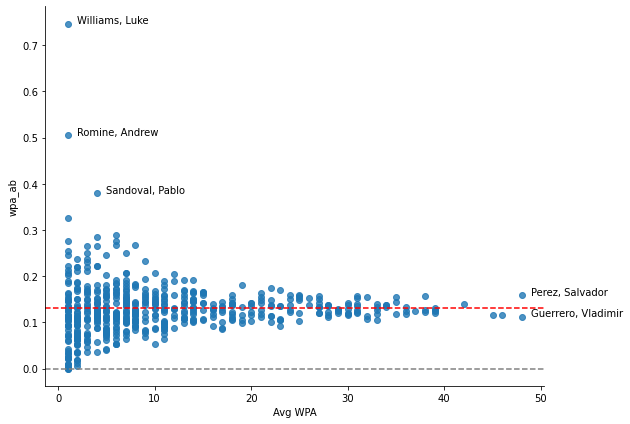

In [24]:
ax = sns.lmplot('count', 'wpa_ab', data=hr_comp, fit_reg=False, size=6, aspect=1.3)
plt.axhline(wpa_hr['wpa_ab'].mean(), color='red', linestyle='--')

count_top = hr_comp[hr_comp['count']>=47]
wpa_top = hr_comp[hr_comp['wpa_ab']>0.35]

def label_point(x, y, val, ax):
    a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
    for i, point in a.iterrows():
        ax.text(point['x']+1, point['y'], str(point['val']))
        
label_point(count_top['count'], count_top['wpa_ab'], count_top['batter_name'], plt.gca())
label_point(wpa_top['count'], wpa_top['wpa_ab'], wpa_top['batter_name'], plt.gca())
plt.xlabel('Avg WPA')
plt.axhline(0, color='grey', linestyle='--')
plt.show()

In [25]:
wpa.groupby('Start_State')['wpa_ab'].mean()

Start_State
000 0    0.032942
000 1    0.022855
000 2    0.016227
001 0    0.042347
001 1    0.054758
001 2    0.051584
010 0    0.054798
010 1    0.045590
010 2    0.043153
011 0    0.051843
011 1    0.054407
011 2    0.071412
100 0    0.055072
100 1    0.042199
100 2    0.031046
101 0    0.061081
101 1    0.065952
101 2    0.062862
110 0    0.072546
110 1    0.067476
110 2    0.059722
111 0    0.067368
111 1    0.080834
111 2    0.099718
Name: wpa_ab, dtype: float64

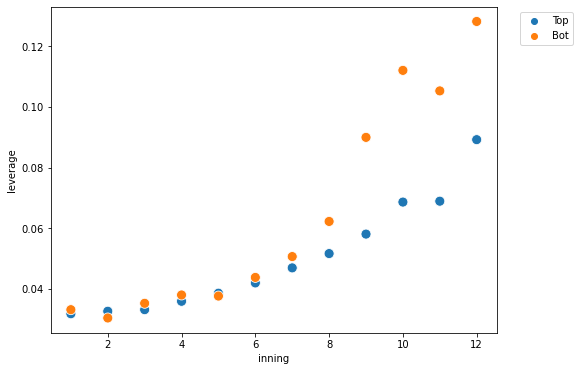

In [26]:
inning_leverage = wpa.groupby(['inning', 'inning_topbot'])['wpa_ab'].std().reset_index().sort_values(by=['inning', 'inning_topbot'], ascending=[True, False]).rename(columns={'wpa_ab': 'leverage'})
inning_12 = inning_leverage[inning_leverage['inning']<13]

plt.figure(figsize=(8,6))
sns.scatterplot('inning', 'leverage', hue='inning_topbot', data=inning_12, s=100)
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left", title='')
plt.show()